# Experiment 4: MC-OCR corpus 

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from image_utils import show_image
from scene_text import visualize_boxes


def show_image_in_row(image_dir: Path, row: pd.Series):
    image_file = image_dir / row['img_id']
    polygons = eval(row['anno_polygons'])
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    image = cv2.imread(image_file)
    assert image.ndim == 3, '3-channel colored image'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    boxes = []
    for polygon in polygons:
        x1, y1, dx, dy = polygon['bbox']
        x2 = x1 + dx
        y2 = y1 + dy
        boxes.append([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
    vis_image = visualize_boxes(image, boxes)
    plt.imshow(vis_image)
    plt.show()

In [2]:
%run prepare_mcocr2021.py

D:\work-in-progress\invoice-extraction-training\prepare_mcocr2021.py:12: UserWarning: 2021 MC-OCR corpus was already prepared.
  warnings.warn('2021 MC-OCR corpus was already prepared.')


In [3]:
data_dir = Path('data') / 'mcocr2021_public'
assert data_dir.is_dir()

train_data_dir = data_dir / 'mcocr_train_data'
assert train_data_dir.is_dir()

train_df_file = train_data_dir / 'mcocr_train_df.csv'
assert train_df_file.is_file()

train_image_dir = train_data_dir / 'train_images'
assert train_image_dir.is_dir()

In [4]:
train_df = pd.read_csv(train_df_file)

print(len(train_df))
train_df.head()

1155


,img_id,anno_polygons,anno_texts,anno_labels,anno_num,anno_image_quality
0,mcocr_public_145013ddcph.jpg,"[{'category_id': 15, 'segmentation': [[231.9, ...",MINIMART ANAN|||Chợ Sủi Phú Thị Gia Lâm|||Ngày...,SELLER|||ADDRESS|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.635309
1,mcocr_public_145013fxcgs.jpg,"[{'category_id': 15, 'segmentation': [[311.6, ...",VinCommerce|||VM + QNH Dự án quỹ đất đường sắt...,SELLER|||ADDRESS|||ADDRESS|||ADDRESS|||TIMESTA...,7,0.774317
2,mcocr_public_145013clltn.jpg,"[{'category_id': 15, 'segmentation': [[626.8, ...",SIEU THI BACH HOA TONG HOP|||Bố 5 Cẩm Tây - Cẩ...,SELLER|||ADDRESS|||TOTAL_COST|||TOTAL_COST|||T...,5,0.664084
3,mcocr_public_145013tmibr.jpg,"[{'category_id': 15, 'segmentation': [[715.5, ...",co.op mart|||Co.opMart HAU GIANG|||188 Hau Gia...,SELLER|||SELLER|||ADDRESS|||ADDRESS|||TIMESTAM...,8,0.715504
4,mcocr_public_145013kgypr.jpg,"[{'category_id': 16, 'segmentation': [[200.5, ...","Tổ 7, Khu Minh Tiến A|||VinCommerce|||Ngày bán...",ADDRESS|||SELLER|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.766884


What are all the `anno_labels`?

In [5]:
labels_set = []
nan_count = 0
for idx in train_df.index:
    labels = train_df.loc[idx, 'anno_labels']
    if isinstance(labels, float):
        nan_count += 1
        print('⚠️ [Index {}] {}'.format(idx, labels))
        continue
    labels_set.extend(labels.split('|||'))
labels_set = set(labels_set)
print('NaN ratio in anno_labels column: {:d}/{:d} ({:.2%})'.format(
    nan_count, len(train_df), nan_count / len(train_df)))
labels_set

⚠️ [Index 1011] nan
⚠️ [Index 1091] nan
NaN ratio in anno_labels column: 2/1155 (0.17%)


{'ADDRESS', 'SELLER', 'TIMESTAMP', 'TOTAL_COST', 'TOTAL_TOTAL_COST'}

Let's see what happens in the rows has `NaN`.

Polygons:
	{'category_id': 15, 'segmentation': [[496.8, 239.9, 496.8, 281.9, 247.8, 281.9, 247.8, 239.9]], 'area': 10458, 'bbox': [248, 240, 249, 42], 'width': 768, 'height': 1024}
	{'category_id': 16, 'segmentation': [[110.1, 344.1, 651.7, 328.2, 651.7, 361.5, 105.9, 378.9]], 'area': 18515, 'bbox': [106, 328, 546, 51], 'width': 768, 'height': 1024}
	{'category_id': 17, 'segmentation': [[373.8, 397.7, 373.8, 426.6, 92.9, 426.6, 92.9, 397.7]], 'area': 8149, 'bbox': [93, 398, 281, 29], 'width': 768, 'height': 1024}
	{'category_id': 18, 'segmentation': [[530.1, 700.3, 530.1, 742.2, 294.1, 742.2, 294.1, 700.3]], 'area': 9912, 'bbox': [294, 700, 236, 42], 'width': 768, 'height': 1024}
	{'category_id': 18, 'segmentation': [[693.7, 697.4, 693.7, 740.8, 544.6, 740.8, 544.6, 697.4]], 'area': 6556, 'bbox': [545, 697, 149, 44], 'width': 768, 'height': 1024}
Texts: Cuitar Cafe|||28 Phan Chu Trinh, Hiệp Phú, Quận 9, Hồ|||Ngày lấp: 03/10/2020|||Thành tiền:|||25,000
Labels: SELLER|||ADDRESS|||TIMESTA

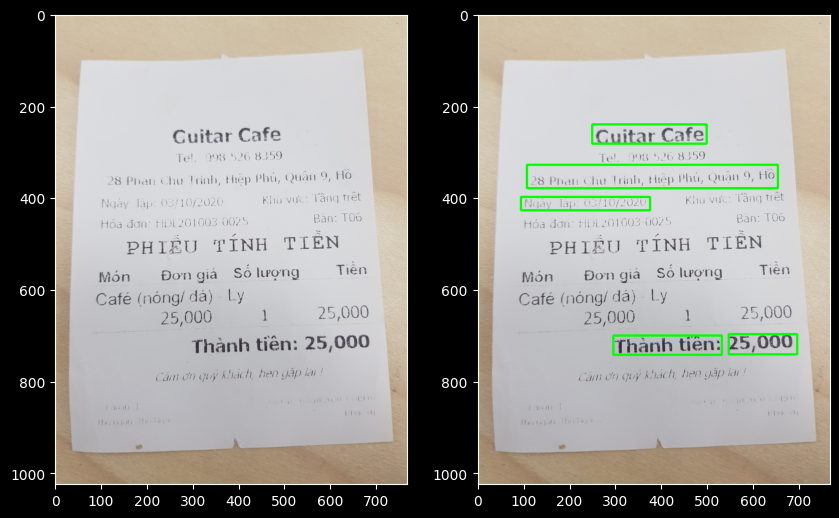

Polygons:
Texts: nan
Labels: nan
Number of text boxes: 0
Image quality: 0.622674


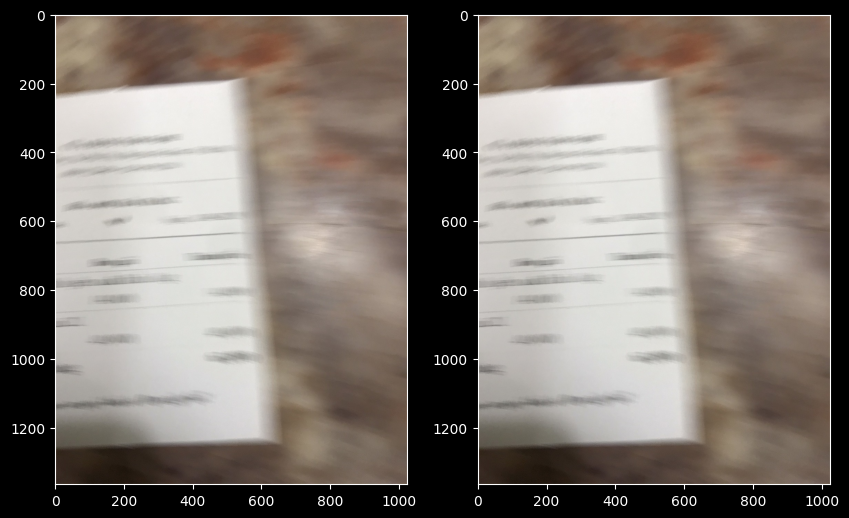

Polygons:
Texts: nan
Labels: nan
Number of text boxes: 0
Image quality: 0.297373


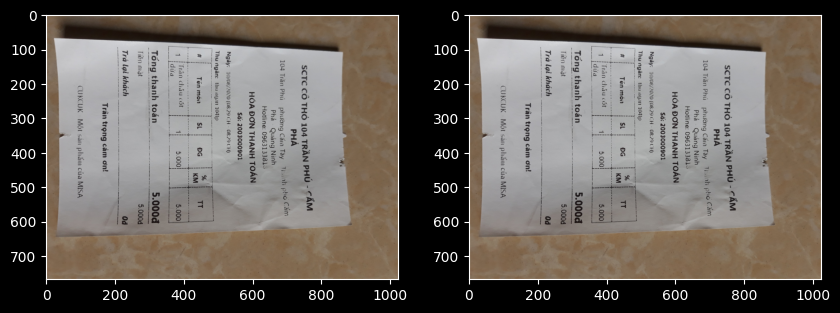

In [6]:
indices = [600, 1011, 1091]

for i in indices:
    row = train_df.iloc[i]
    print('Polygons:')
    for polygon in eval(row['anno_polygons']):
        print('\t{}'.format(polygon))
    print('Texts:', row['anno_texts'])
    print('Labels:', row['anno_labels'])
    print('Number of text boxes:', row['anno_num'])
    print('Image quality:', row['anno_image_quality'])
    show_image_in_row(train_image_dir, row)